In [2]:
import netCDF4
from pyiron import Project
import numpy as np
import h5py
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from pyiron_base import load
import newmodn as nm

In [3]:
pr = Project ('Platinum_Iridium')

In [4]:
working_directory="/u/skatnagallu/pyiron/projects/HEA_FIM/PtIrAu_FIM_contrast/Pt1Ir_210_relax_wf_4_0_VA_hdf5/Pt1Ir_210_relax_wf_4_0_VA"
dft= nm.sx_waves_reader(working_directory,working_directory+'/waves.sxb')
potentials=nm.potential(working_directory)
total_V,V1,cell= potentials.potential_cell()


In [5]:
total_V.shape

(60, 56, 220)

In [7]:
 Simulator = {
            'working_directory': '/u/skatnagallu/pyiron/projects/HEA_FIM/PtIrAu_FIM_contrast/Pt1Ir_210_relax_wf_4_0_VA_hdf5/Pt1Ir_210_relax_wf_4_0_VA',
            'ik': 0,
            'z_max': 40,
            'izstart_min': 115,
            'izend': 100,
            'cutoff': 10,
            'limit': 1e-10,
            'E_fermi': 52.1539 ,
            'E_max': 57.1913,
            'ionization_energies': [10., 15., 21.5]
    }

In [9]:
x_1D= np.linspace(0,cell[0,0],total_V.shape[0])
dx=x_1D[1]-x_1D[0]
y_1D= np.linspace(0,cell[1,1],total_V.shape[1])
dy=y_1D[1]-y_1D[0]
z_1D= np.linspace(0,cell[2,2],total_V.shape[2])
dz=z_1D[1]-z_1D[0]
ispin=0
i=380
ik=0
z_max=40
Nz_max= int(z_max/dz)
waves=nm.extra_waves(total_V,dz,cell,Nz_max,dft,inputDict=Simulator)
psi_extra,gk_1,gk_2 = waves.get_psi(i,ispin,ik)

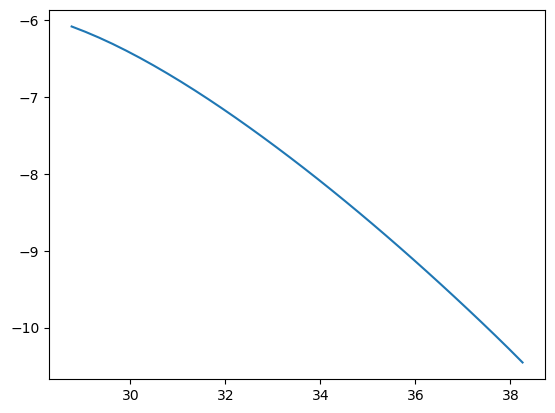

In [10]:
plt.plot(z_1D[Simulator['izend']:Nz_max-5],np.log10(np.abs(psi_extra[28,26,Simulator['izend']:Nz_max-5])))


In [11]:
fim=nm.FIM_simulations(dft,psi_extra,total_V,inputDict=Simulator)
fim.sum_all_states(ik)

In [16]:
all_totals = dict ()
Nx,Ny=60,56
for ik in range(25):
        with h5py.File(f'/cmmc/u/sbhatt/pyiron/my_module/Platinum_Iridium/PtIr{ik}_hdf5/PtIr{ik}/partial_dos0.h5', 'r') as handle:
            for varname in handle.keys ():
                if 'IE=' in varname:
                    IE = float(str(varname).replace('IE=',''))
                    if IE not in all_totals.keys ():
                        all_totals[IE] = np.zeros((Nx,Ny), dtype=np.float64)
                    all_totals[IE] += np.asarray(handle[varname])

In [19]:
all_totals

{10.0: array([[9.34355934e-15, 9.37450113e-15, 9.28117273e-15, ...,
         8.54267333e-15, 8.90707156e-15, 9.18335253e-15],
        [1.22130437e-14, 1.22045241e-14, 1.19561058e-14, ...,
         1.08601404e-14, 1.15078219e-14, 1.19735525e-14],
        [1.56887293e-14, 1.56353919e-14, 1.52173697e-14, ...,
         1.37482779e-14, 1.47020694e-14, 1.53680746e-14],
        ...,
        [3.70931912e-15, 3.82394160e-15, 4.11811918e-15, ...,
         4.45609678e-15, 4.01784303e-15, 3.77120676e-15],
        [5.16805756e-15, 5.25828588e-15, 5.42871336e-15, ...,
         5.39351699e-15, 5.22697429e-15, 5.15512585e-15],
        [7.02112613e-15, 7.08435211e-15, 7.12846848e-15, ...,
         6.73906222e-15, 6.83647516e-15, 6.93580027e-15]]),
 15.0: array([[6.83217106e-17, 6.80160346e-17, 6.70324425e-17, ...,
         6.52702807e-17, 6.68933149e-17, 6.79362250e-17],
        [8.52067679e-17, 8.47060726e-17, 8.28945394e-17, ...,
         7.89880866e-17, 8.22553625e-17, 8.43715889e-17],
        [1.04

In [17]:
xp =np.linspace(0,27,270)
yp= np.linspace(0,18,180)
FIM_image_ex_all=np.zeros([xp.shape[0],yp.shape[0]],dtype=np.complex128)

# interpolation of DFT_total3
prho_rec_ex_all= np.fft.ifft2(all_totals[21.5])
for ix in range(xp.shape[0]):
    for iy in range(yp.shape[0]):
        x=xp[ix]
        y=yp[iy]
        phase_1=np.exp(-1j*(gk_1[:,0]*x+gk_1[:,1]*y))
        phase_2= np.exp(-1j*(gk_2[:,0]*x+gk_2[:,1]*y))
        phase=np.outer(phase_1,phase_2)
        FIM_image_ex_all[ix,iy] =np.sum(prho_rec_ex_all.flatten()*phase.flatten())

In [18]:
FIM_image_ex_all

array([[3.05881459e-20+1.20370622e-35j, 3.04883700e-20-6.01853108e-36j,
        3.03540524e-20+0.00000000e+00j, ...,
        2.12415349e-20-1.50463277e-36j, 2.09776850e-20+0.00000000e+00j,
        2.07416858e-20-6.01853108e-36j],
       [3.26453159e-20+6.01853108e-36j, 3.25468998e-20-6.01853108e-36j,
        3.24025987e-20+0.00000000e+00j, ...,
        2.06433488e-20-3.00926554e-36j, 2.02752342e-20-7.52316385e-36j,
        1.99423343e-20-7.52316385e-36j],
       [3.47899345e-20+0.00000000e+00j, 3.46928999e-20+0.00000000e+00j,
        3.45385756e-20-6.01853108e-36j, ...,
        2.01159227e-20-4.51389831e-36j, 1.96425890e-20-7.52316385e-36j,
        1.92118318e-20-6.01853108e-36j],
       ...,
       [8.12456228e-21-6.01853108e-36j, 8.16791187e-21-3.00926554e-36j,
        8.35348030e-21+0.00000000e+00j, ...,
        4.17043812e-20+3.00926554e-36j, 4.28965328e-20+9.02779661e-36j,
        4.39819334e-20+3.00926554e-36j],
       [7.45626472e-21-3.00926554e-36j, 7.49090369e-21-6.01853108e-3

In [25]:
toplayer=[(x /1.89,y/ 1.89) for x,y,z in struct.positions  if z>14]


[]

In [26]:
toplayer

[]

In [17]:
BOHR_TO_Angstrom= scipy.constants.physical_constants["Bohr radius"][0]*1e+10


1.2309604998655733e-19
1e-19
1.3e-19
[]


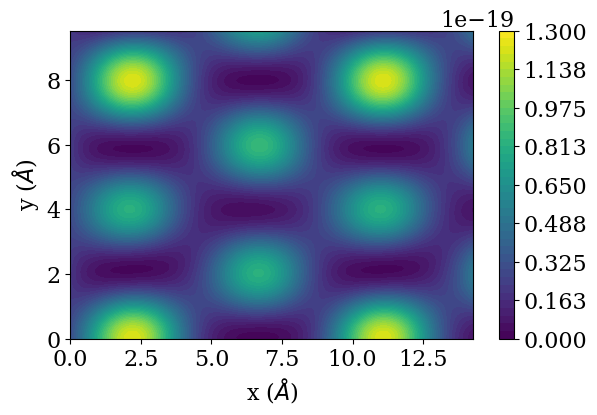

In [27]:
vmax=np.max(FIM_image_ex_all.real)
print(vmax)
vmax_lev=np.power(10., np.trunc(np.log10(vmax))-1)
print(vmax_lev)
vmax_lev=(np.trunc(vmax / vmax_lev * 10.)+1)*0.1 * vmax_lev
print(vmax_lev)
plt.figure(figsize=[6.5,4])
plt.contourf(xp/1.89,yp/1.89,FIM_image_ex_all.real.T,vmin=0,vmax=vmax_lev,levels=np.linspace(0,vmax_lev,41))
plt.rcParams['font.size'] = '16'
plt.rcParams['font.family'] ='serif'
plt.xlabel('x ($\AA$)')
#plt.xticks([0,5,10,15,20,25])
plt.ylabel('y ($\AA$)')
plt.colorbar()
#toplayer=[(x /1.89,y/ 1.89) for x,y,z in struct.positions  if z>14]
#for (x,y) in toplayer[0:2]:
  #  plt.text(x/0.529,y/0.529, 'Pt', style='normal',fontsize=14,color='white')
#plt.text(toplayer[2][0]*1.89,toplayer[2][1]*1.89, 'Ir', style='normal',fontsize=14,color='black')
#plt.figtext(0.12, 0.8, 'EXTRA (I=21.5 eV)',color='white')
print (toplayer)
plt.savefig("PtIr_EXTRA.png",bbox_inches="tight", dpi=400)

In [12]:
from pyiron_atomistics.sphinx.structure import read_atoms
struct=read_atoms("/u/skatnagallu/pyiron/projects/HEA_FIM/PtIrAu_FIM_contrast/Pt1Ir_210_relax_wf_4_0_VA_hdf5/Pt1Ir_210_relax_wf_4_0_VA/relaxedStr.sx") 

In [13]:
struct

Ir: [ 2.26398431e+00 -4.97426578e-07  1.32298984e+01]
Pt: [6.66627766 0.         0.        ]
Pt: [0.44441851 0.         0.88883702]
Pt: [7.55511468 1.9875     1.77767404]
Pt: [1.33325553 1.9875     2.66651106]
Pt: [8.4439517  0.         3.55534809]
Pt: [6.66627766 1.9875     4.44418511]
Pt: [0.44441851 1.9875     5.33302213]
Pt: [7.55511468 0.         6.22185914]
Pt: [ 1.32840514e+00 -1.16418986e-07  7.15313124e+00]
Pt: [8.44120569 1.99157688 8.0588076 ]
Pt: [ 6.69324097e+00 -1.53461391e-07  8.95124256e+00]
Pt: [ 4.84369755e-01 -3.81007592e-07  9.85049751e+00]
Pt: [ 7.5700578   1.98258077 10.74304855]
Pt: [ 1.29175126  2.00411883 11.78605218]
Pt: [ 8.51051278e+00 -6.98513918e-07  1.25966613e+01]
Pt: [ 6.75082453  1.97963886 13.3347332 ]
Pt: [2.22209255 1.9875     0.        ]
Pt: [4.88860362 1.9875     0.88883702]
Pt: [3.11092958 0.         1.77767404]
Pt: [5.77744063 0.         2.66651106]
Pt: [3.9997666  1.9875     3.55534809]
Pt: [2.22209255 0.         4.44418511]
Pt: [4.88860362 0. 

In [15]:
Nz=220
relcoords=np.matmul(np.linalg.inv(np.asarray(struct.cell)).T,struct.positions[-1])
print (struct.cell[0] * relcoords[0] + struct.cell[1]*relcoords[1] +struct.cell[2]*relcoords[2], relcoords * [Nx,Ny,Nz])

[ 2.36266078  3.9749991  13.36872524] [15.94889091 27.99999363 88.23564602]


In [14]:
struct.plot3d()

NGLWidget()